In [1]:
import networkx as net
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import nxviz as nv

In [2]:
g=net.Graph()

In [3]:
def clean_line(line):
    invalids = ['"', '\n']
    for n in invalids:
        line = line.replace(n, '')
        
    return line

def extract_data(file_loc, props):
    # Read in file
    file_obj = open(file_loc, "r",encoding="utf8")
    lines = file_obj.readlines()
    file_obj.close()
    

    #Takes the lines that were read in, does a split to create an array, then zips
    #with the props to create a 2d array, and then forms a dictionary from that 2d array,
    #and returns a list of those dictionaries.
    return list(map(lambda x: dict(zip(props, clean_line(x).split(","))), lines))
    

In [4]:
airport_props = [
        "airport_id",
        "name",
        "city",
        "country",
        "iata",
        "icao",
        "lat",
        "lon",
        "altitude",
        "timezone",
        "dst",
        "tz_database_time_zone",
        "type",
        "source"
]

route_props = [
        "airline",
        "airline_id",
        "source_airport",
        "source_airport_id",
        "destination_airport",
        "destination_airport_id",
        "codeshare",
        "stops",
        "equipment"
        ]

airlines_props = ["airline_id",
"name",
"alias",
"iata",
"icao",
"callsign",
"country",
"active"]

In [5]:
routes = extract_data("./data/routes.dat", route_props)
airports = extract_data("./data/airports.dat", airport_props)
airlines = extract_data('./data/airlines.dat',airlines_props)[1:]

In [6]:
routes_df = pd.DataFrame(routes)
airlines_df = pd.DataFrame(airlines)

In [7]:
routes_airline = routes_df.merge(airlines_df,left_on="airline_id",right_on="airline_id",how="inner")[['airline', 'airline_id', 'codeshare', 'destination_airport',
       'destination_airport_id', 'equipment', 'source_airport',
       'source_airport_id', 'stops','name','active']].to_dict(orient='records')

In [8]:
#Centrality

In [9]:
for airport in airports:
    g.add_node(airport['iata'], name= airport['name'], city= airport['city'], timezone = airport['timezone'], lat = airport['lat'], lon = airport['lon'])

In [10]:
for route in routes_airline:
    g.add_edge(route['source_airport'],route['destination_airport'], \
               stops =route['stops'],equipment=route['equipment'], airline_id =route['airline_id'], 
              name = route['name'], active =route['active'])

In [11]:
g.edges(data=True)

[('GKA',
  'HGU',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8 DHT',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('GKA',
  'LAE',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('GKA',
  'MAG',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('GKA',
  'POM',
  {'active': 'Y',
   'airline_id': '328',
   'equipment': 'DH4 DH8 DH3',
   'name': 'Air Niugini',
   'stops': '0'}),
 ('MAG',
  'HGU',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('MAG',
  'LAE',
  {'active': 'Y',
   'airline_id': '1308',
   'equipment': 'DH8',
   'name': 'Airlines PNG',
   'stops': '0'}),
 ('MAG',
  'WWK',
  {'active': 'Y',
   'airline_id': '328',
   'equipment': '100 DH4',
   'name': 'Air Niugini',
   'stops': '0'}),
 ('MAG',
  'MAS',
  {'active': 'Y',
   'airline_id': '328',
   'equipment': '1

In [ ]:
net.draw(g)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()


In [ ]:
plt.show()

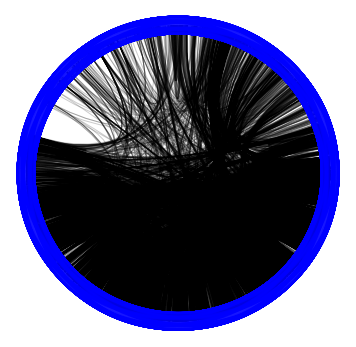

In [12]:
circos_plot = nv.CircosPlot(g)
circos_plot.draw()
plt.show()

In [16]:
def sorted_map(map1):
    ms = sorted(map1.items(), key =lambda k: -k[1])
    return ms

In [27]:
cs = sorted_map(net.closeness_centrality(g))
deg = sorted_map(net.degree(g))
bs = sorted_map(net.betweenness_centrality(g))


In [28]:
names1 = [x[0] for x in cs[:10]]
names2 = [x[0] for x in deg[:10]]
names3 = [x[0] for x in bs[:10]]

[('FRA', 0.22808075265078118),
 ('CDG', 0.22680283369561238),
 ('LHR', 0.22532082098753362),
 ('DXB', 0.22356240420710502),
 ('AMS', 0.22300015145400928),
 ('LAX', 0.22038717773002459),
 ('JFK', 0.21927122758372325),
 ('IST', 0.21641692987459063),
 ('YYZ', 0.21576492058412255),
 ('PEK', 0.21539054536043697),
 ('MUC', 0.2148933946498532),
 ('ORD', 0.21471993365324926),
 ('FCO', 0.21373407537201305),
 ('NRT', 0.21358697690307155),
 ('DOH', 0.21319570238618932),
 ('EWR', 0.21229634758191512),
 ('ICN', 0.21219957431806014),
 ('MAD', 0.21188566962232336),
 ('ZRH', 0.2112366721090162),
 ('HKG', 0.21032997454433272)]

In [ ]:
names = list(set(names1) | set(names2) | set(names3))
table = [[name,cs[name], deg[name], bs[name]] for name in names]
table

In [ ]:
#Shortest Path

In [26]:
net.shortest_path(g, 'RDU','MAS')

['RDU', 'LAX', 'BNE', 'POM', 'MAS']

In [33]:
net.dijkstra_path(g, 'RDU','MAS')

['RDU', 'DFW', 'BNE', 'POM', 'MAS']